[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/alucantonio/data_enhanced_simulation/blob/master/9_REINFORCE.ipynb)

# Policy gradient methods

As an alternative to Deep Q-Learning (DQN) where the policy is implicit, we can train a (deep) neural network to
output the _probability distribution_ over the actions given a state as an input
(**policy network**). Hence, we can directly sample an action from the policy, without
the need for an epsilon-greedy strategy. This class of algorithms is called **policy
gradient methods** and there are many different types of these.

In a _stochastic policy gradient_ method the output of the neural network is an _action vector_ that represents
a probability distribution. This allows the agent to explore enough, before the action
distribution converges to producing the single best action (degenerate probability
distribution), when the environment is stationary (constant distribution of
states and rewards).

The probability of an action, given the parameters $\theta$ of the policy network, is
denoted $\pi_s(a|\theta)$. When training the policy network, we want it to assign more probability to the winning
actions, based on a collection of episodes (sequences of states, actions and rewards
recorded while interacting with the environment). Our objective then is to maximize the
performance of the parameterized policy using **gradient ascent**. To do that, we define an objective function
$J(\theta)$, that is, the **expected cumulative reward** (or return), and we want to find the set of
parameters $\theta$ that maximizes this objective function.

Advantages:
- Can learn stochastic policies
- Do not need to store action-values
- Better convergence properties
- No perceptual aliasing issue (states that seem (or are) the same but need different actions)
- Eﬀective in high-dimensional or continuous action spaces

Disadvantages:
- Typically converge to a local rather than global optimum
- Evaluating a policy is typically inefficient and high variance

More info [here](https://huggingface.co/learn/deep-rl-course/unit4/hands-on).

<figure>
    <img src="policy_grad_loss.png" alt="Caption" width="800" />
    <figcaption>Policy gradient objective function (taken from huggingface.co).</figcaption>
</figure>

Here, we compute the expected cumulative return by summing over all trajectories
  $\tau$ the probability $P(\tau;\theta)$ of taking that trajectory given $\theta$, multiplied by
  the _cumulative reward_ $R(\tau)$ of this trajectory, i.e.
  
$$ R(\tau) = \sum_{k=0}^{T-1} \gamma^k r_k $$

with $\gamma < 1$ the _discount factor_, and $T$ the number of time steps in the episode.

  Thanks to the **Policy Gradient Theorem**, we
  can estimate $\nabla J$ as:

  $$\nabla J(\theta) = \mathbb{E}_{\tau \sim \pi}[\nabla \log \pi_s(a|\theta)R(\tau)]$$

  A Monte Carlo estimate of this gradient is given by:

<figure>
    <img src="policy_gradient_multiple.png" alt="Caption" width="800" />
    <figcaption>Policy gradient objective function (taken from huggingface.co).</figcaption>
</figure>

## The REINFORCE algorithm

The REINFORCE algorithm is a simple policy gradient method. We will apply it to solve
the `CartPole` environment (see the docs [here](https://gymnasium.farama.org/environments/classic_control/cart_pole/) and familiarize with the state and actions).

In [1]:
import numpy as np
from flax import nnx
import gymnasium as gym
from matplotlib import pyplot as plt
import optax
import jax.numpy as jnp
import jax


env = gym.make("CartPole-v1")

<figure>
    <img src="reinforce_pseudocode.png" alt="Caption" width="800" />
    <figcaption>Pseudocode of the REINFORCE algorithm (taken from huggingface.co).</figcaption>
</figure>

Notice that, when we calculate the return $G_t$ (line 6), we sum the discounted rewards starting at
timestep $t$. Why? Because our policy should only reinforce actions on the basis of the
consequences: so rewards obtained before taking an action are useless (since they were
not because of the action), only the ones that come after the action matters. The
computation of $G_t$ can be done efficiently using this relation:

$$G_t = R_t + \gamma G_{t+1}$$

Here is its implementation in `jax`:

In [2]:
@jax.jit
def discount_rewards(rewards, gamma=0.99):

    def discount_step(carry, reward):
        cumulative_reward = reward + gamma * carry
        return cumulative_reward, cumulative_reward
    
    # Use reverse to match the backward computation in the loop
    _, discounted_rewards = jax.lax.scan(discount_step, 0.0, rewards[::-1])

    # Normalize the rewards to be within the [0,1] interval for numerical stability
    discounted_rewards /= discounted_rewards.max()
    
    # Reverse the result to match the original order
    return discounted_rewards[::-1]

1. Define the policy network. Use a Leaky-ReLU activation for 1 hidden layer and a softmax
function on the output.

In [3]:
#@title Solution:

class PolicyNetwork(nnx.Module):
  def __init__(self, l1, l2, l3, rngs: nnx.Rngs):
    self.linear1 = nnx.Linear(l1, l2, rngs=rngs)
    self.linear2 = nnx.Linear(l2, l3, rngs=rngs)

  def __call__(self, x):
    y = nnx.leaky_relu(self.linear1(x))
    y = self.linear2(y)
    y = nnx.softmax(y)
    return y

l1 = 4
l2 = 150
l3 = 2

learning_rate = 0.002
model = PolicyNetwork(l1, l2, l3, nnx.Rngs(0))
optimizer = nnx.Optimizer(model, optax.adam(learning_rate))

2. Define the loss function `loss_fn` and the `train_step` function that performs one update of the
weights of the policy network.

In [4]:
#@title Solution:

@nnx.jit
def loss_fn(model, states, actions, discounted_rewards):
    log_probs = jnp.log(jnp.take_along_axis(model(states), actions[:, None], axis=1).squeeze())
    return -jnp.sum(log_probs * discounted_rewards)


@nnx.jit
def train_step(model, optimizer, states, actions, discounted_rewards):
    loss, grads = nnx.value_and_grad(loss_fn)(model, states, actions, discounted_rewards)
    optimizer.update(grads)
    return loss

3. Complete the main training loop and train the policy network.

In [ ]:
MAX_DUR = 200
MAX_EPISODES = 500
gamma = 0.99
score = np.zeros(MAX_EPISODES)

for episode in range(MAX_EPISODES):
    curr_state = env.reset()[0]
    states, actions = [], []

    num_t = MAX_DUR 
    
    for t in range(MAX_DUR):
        # Estimate action probabilities for the current state using the policy network
        # ...

        # Perform action and get new state and terminated/truncated flags from the environment
        # ...

        # Record episode data (states and actions)
        # states ...
        # actions ...

        # Update the current state with the next state got from the environment
        curr_state = next_state

        if terminated or truncated:
            num_t = t + 1
            break

    # Compute episode score and array of rewards
    # score[episode] = ... 
    # rewards = ...

    # Compute discounted future rewards
    disc_future_rewards = discount_rewards(rewards)

    # standardization of returns to make training more stable
    # (see https://huggingface.co/learn/deep-rl-course/unit4/hands-on)
    disc_future_rewards = (disc_future_rewards-disc_future_rewards.mean())/(disc_future_rewards.std())

    states = np.array(states)
    actions = np.array(actions)

    # Update policy parameters
    loss = train_step(model, optimizer, states, actions, disc_future_rewards) 
        
    if episode % 100 == 0:
        # Print episode number and total reward
        # ...

In [5]:
#@title Solution:

MAX_DUR = 200
MAX_EPISODES = 500
gamma = 0.99
score = np.zeros(MAX_EPISODES)

for episode in range(MAX_EPISODES):
    curr_state = env.reset()[0]

    states = np.zeros((MAX_DUR, 4))
    actions = np.zeros(MAX_DUR, dtype=np.long)
    rewards = np.zeros(MAX_DUR)

    num_t = MAX_DUR 
    
    for t in range(MAX_DUR):
        act_prob = model(curr_state)
        action = np.random.choice(np.array([0,1]), p=act_prob.__array__())

        next_state, _, terminated, truncated, info = env.step(action)

        # Record episode data
        states[t] = curr_state
        actions[t] = action

        curr_state = next_state

        if terminated or truncated:
            num_t = t + 1
            break

    ep_len = num_t
    score[episode] = ep_len
    rewards[:ep_len] = 1.

    # pick only the meaningful rewards (needed to properly compute loss)
    mask = rewards

    disc_future_rewards = discount_rewards(rewards)*mask

    # standardization of returns to make training more stable
    # (see https://huggingface.co/learn/deep-rl-course/unit4/hands-on)
    # disc_future_rewards = (disc_future_rewards-disc_future_rewards.mean())/(disc_future_rewards.std())

    # print(disc_future_rewards*rewards)

    states = np.array(states)
    actions = np.array(actions)

    loss = train_step(model, optimizer, states, actions, disc_future_rewards) 
        
    if episode % 100 == 0:
        print(f"Episode {episode}, Total Reward: {ep_len}")

Episode 0, Total Reward: 22
Episode 100, Total Reward: 11
Episode 200, Total Reward: 200
Episode 300, Total Reward: 189
Episode 400, Total Reward: 200


4. Plot the running mean of the scores (episode duration) obtained during the training episodes.

In [6]:
def running_mean(x, N=50):
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y

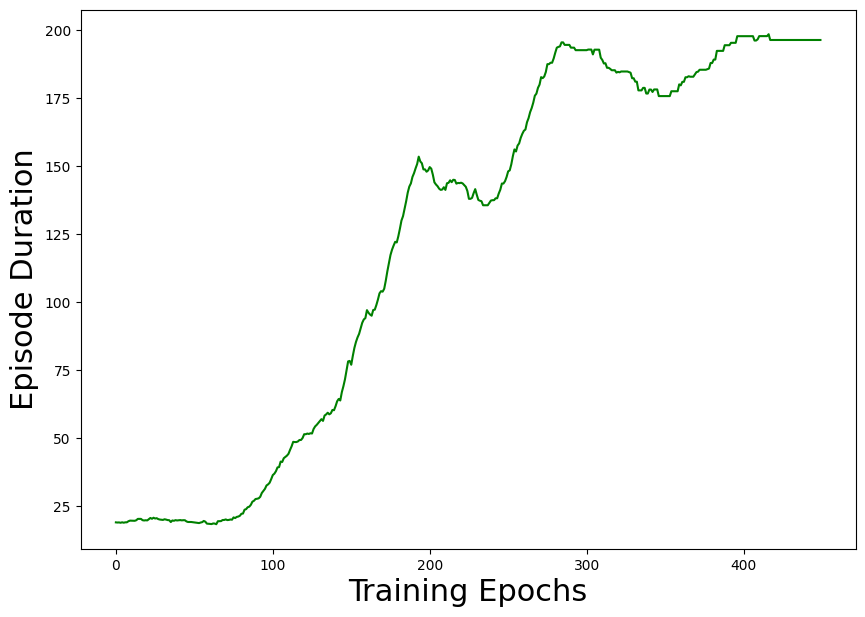

In [7]:
avg_score = running_mean(score, 50)
plt.figure(figsize=(10,7))
plt.ylabel("Episode Duration",fontsize=22)
plt.xlabel("Training Epochs",fontsize=22)
plt.plot(avg_score, color='green')
plt.show()

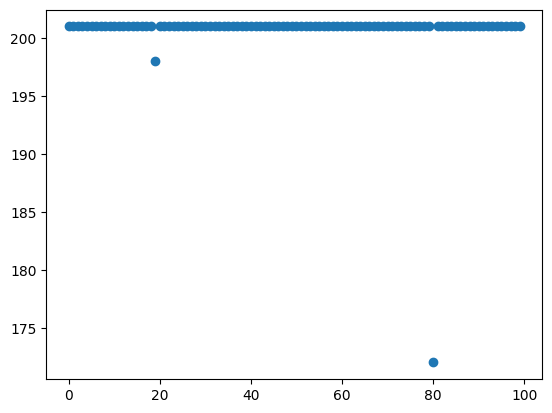

In [8]:
score = []
games = 100
done = False
state1 = env.reset()[0]
for i in range(games):
    t=0
    while True:
        if type(state1) is tuple:
            state1 = state1[0]
        pred = model(state1)
        action = np.random.choice(np.array([0,1]), p=pred.__array__())
        state2, reward, terminated, truncated, info = env.step(action)
        state1 = state2
        if(type(state1) == 'tuple'):
            state1 = state2[0]
        
        t += 1
        if t > MAX_DUR or truncated or terminated:
            break;
    state1 = env.reset()
    done = False
    score.append(t)

score = np.array(score)
plt.scatter(np.arange(score.shape[0]),score)
plt.show()

**Bonus exercise**: try to solve the [Taxi](https://gymnasium.farama.org/environments/toy_text/taxi/) environment.